## Data Loading and Inspection

In [18]:
import pandas as pd
import numpy as np

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [19]:
# Load dataset
df = pd.read_csv("D:/WORKSPACE_CS/LJMU_Research/other/dash/health_policy_recomendation/src/health_policy_recomendation/data/ushealthinsurance_with_company3.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1338 non-null   int64  
 1   sex                1338 non-null   object 
 2   bmi                1338 non-null   float64
 3   children           1338 non-null   int64  
 4   smoker             1338 non-null   object 
 5   region             1338 non-null   object 
 6   charges            1338 non-null   float64
 7   insurance_company  1338 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 83.8+ KB


In [20]:
df.head()

,age,sex,bmi,children,smoker,region,charges,insurance_company
0,19,female,27.900,0,yes,southwest,16884.92400,Company C
1,18,male,33.770,1,no,southeast,1725.55230,Company D
2,28,male,33.000,3,no,southeast,4449.46200,Company D
3,33,male,22.705,0,no,northwest,21984.47061,Company C
4,32,male,28.880,0,no,northwest,3866.85520,Company D


In [21]:
df['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [22]:
df['insurance_company'].value_counts(normalize=True)

insurance_company
Company D    0.415546
Company A    0.336323
Company C    0.132287
Company B    0.115845
Name: proportion, dtype: float64

## Feature Engineering

In [23]:
q1 = df['charges'].quantile(0.25)
q3 = df['charges'].quantile(0.75)

df['budget'] = pd.cut(
    df['charges'],
    bins=[-float('inf'), q1, q3, float('inf')],
    labels=['low', 'medium', 'high']
)

df['budget'] = df['budget'].astype('object')

In [24]:
def feedback_score(row):
    # budget_score = row['budget'].map({'low': 5, 'medium': 3, 'high': 1})

    # score = (
    #     budget_score + 
    #     row['smoker'].map({'yes': -1, 'no': 1}) + 
    #     row['bmi'].apply(lambda x: 1 if x < 25 else -1)
    # )

    # return score.clip(0, 5)

    budget_score = {'low': 5, 'medium': 3, 'high': 1}.get(row['budget'], 0)
    smoker_score = {'yes': -1, 'no': 1}.get(row['smoker'], 0)
    bmi_score = 1 if row['bmi'] < 25 else -1

    score = budget_score + smoker_score + bmi_score

    # Clip the score between 0 and 5
    return max(0, min(5, score))


df['feedback'] = df.apply(feedback_score, axis=1)

In [25]:
def health_score(row):
    score = 2
    if row['bmi'] < 25:
        score += 1
    elif row['bmi'] >= 30:
        score -= 1

    score += 1 if row['smoker'] == 'no' else -1
    return score

df['health_score'] = df.apply(health_score, axis=1)

health score (from BMI + smoker)  
```
BMI | Smoker | Final Score
≥30 | Yes | 0
25–29.9 | No | 3
<25 | No | 4
```

'age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'budget', 'feedback', 'health_score'

In [26]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'insurance_company', 'budget', 'feedback', 'health_score'],
      dtype='object')

## EDA

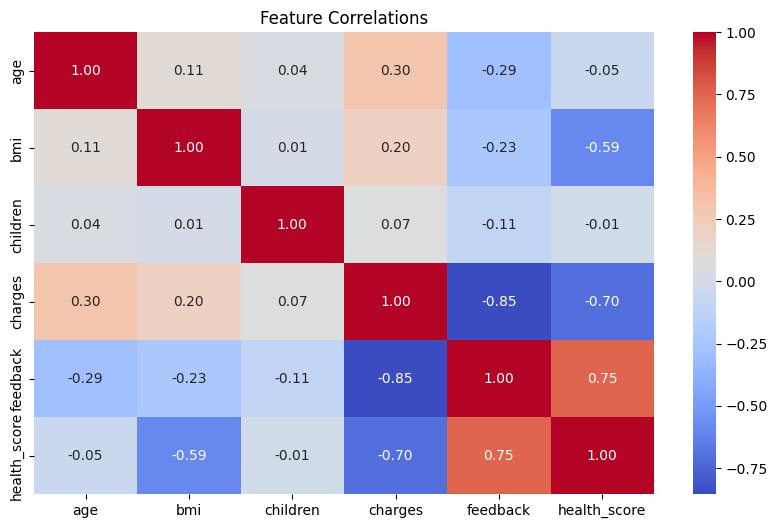

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Heatmap for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.show()

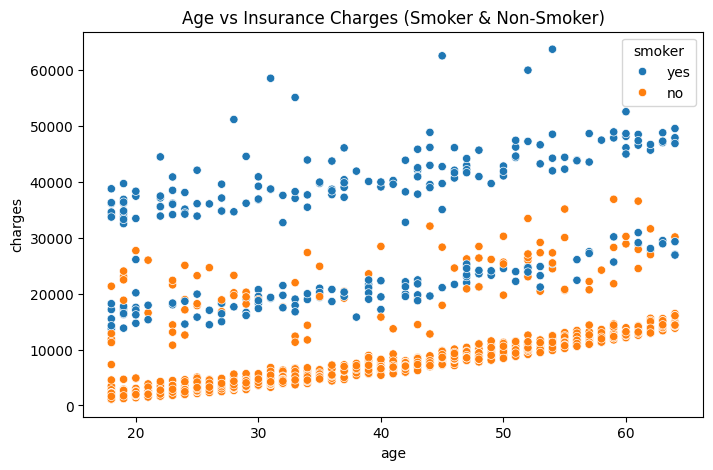

In [12]:
# Age vs Charges

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["age"], y=df["charges"], hue=df["smoker"])
plt.title("Age vs Insurance Charges (Smoker & Non-Smoker)")
plt.show()

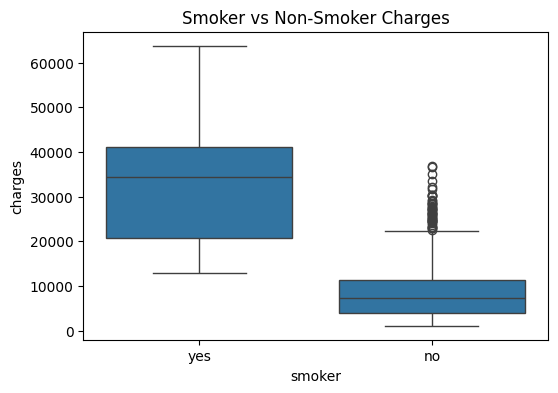

In [13]:
# Smoker Impact on Charges

plt.figure(figsize=(6, 4))
sns.boxplot(x=df["smoker"], y=df["charges"])
plt.title("Smoker vs Non-Smoker Charges")
plt.show()

## Approach 2: ML model based recomendation

In [27]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical columns to numerical
le = LabelEncoder()
df['insurance_company'] = le.fit_transform(df['insurance_company'])

In [28]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'insurance_company', 'budget', 'feedback', 'health_score'],
      dtype='object')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1338 non-null   int64  
 1   sex                1338 non-null   object 
 2   bmi                1338 non-null   float64
 3   children           1338 non-null   int64  
 4   smoker             1338 non-null   object 
 5   region             1338 non-null   object 
 6   charges            1338 non-null   float64
 7   insurance_company  1338 non-null   int32  
 8   budget             1338 non-null   object 
 9   feedback           1338 non-null   int64  
 10  health_score       1338 non-null   int64  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 109.9+ KB


In [30]:
df.describe()

,age,bmi,children,charges,insurance_company,feedback,health_score
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,1.627055,3.005232,2.245142
std,14.049960,6.098187,1.205493,12110.011237,1.318671,1.758612,1.109419
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,3.000000,2.000000
50%,39.000000,30.400000,1.000000,9382.033000,2.000000,3.000000,2.000000
75%,51.000000,34.693750,2.000000,16639.912515,3.000000,5.000000,3.000000
max,64.000000,53.130000,5.000000,63770.428010,3.000000,5.000000,4.000000


In [31]:
df['feedback'].describe()

count    1338.000000
mean        3.005232
std         1.758612
min         0.000000
25%         3.000000
50%         3.000000
75%         5.000000
max         5.000000
Name: feedback, dtype: float64

In [32]:
# We will not be using column 'charges'
df.drop(columns=['charges'], inplace=True)

In [33]:
df.isnull().sum()

age                  0
sex                  0
bmi                  0
children             0
smoker               0
region               0
insurance_company    0
budget               0
feedback             0
health_score         0
dtype: int64

In [34]:
from sklearn.model_selection import train_test_split

# Step 3: Drop original charges column
X = df.drop(['insurance_company'], axis=1)

X_encoded = pd.get_dummies(X, columns=['sex','smoker','region', 'budget'], drop_first=True)

y = df['insurance_company']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=42, stratify=y)

In [35]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 1780, number of used features: 12
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

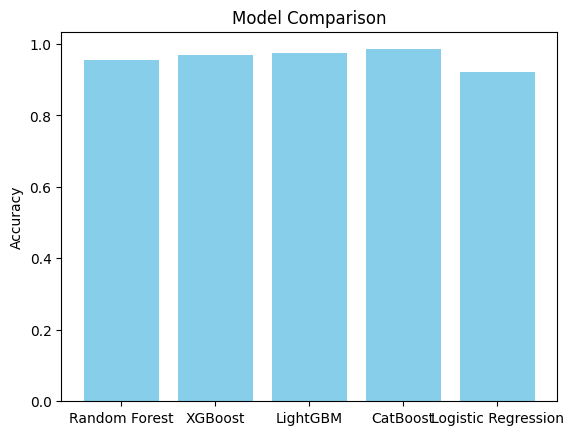

In [37]:
from matplotlib import pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(max_depth=4, random_state=42),
    "CatBoost": CatBoostClassifier(depth=4, iterations=100,  random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=100, random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    # print(f"\n{name} Accuracy: {acc:.4f}")
    # print(classification_report(y_test, y_pred))

# Show comparison
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

In [38]:
results

{'Random Forest': 0.9552238805970149,
 'XGBoost': 0.9701492537313433,
 'LightGBM': 0.9738805970149254,
 'CatBoost': 0.9850746268656716,
 'Logistic Regression': 0.9216417910447762}

In [39]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on balanced data
rf.fit(X_resampled, y_resampled)

# rf.fit(X_train, y_train)

# Evaluate
accuracy = rf.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.9776


In [40]:
y_pred = rf.predict(X_test)

In [41]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

0.9776119402985075
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        90
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        36
           3       0.96      0.98      0.97       111

    accuracy                           0.98       268
   macro avg       0.99      0.98      0.98       268
weighted avg       0.98      0.98      0.98       268



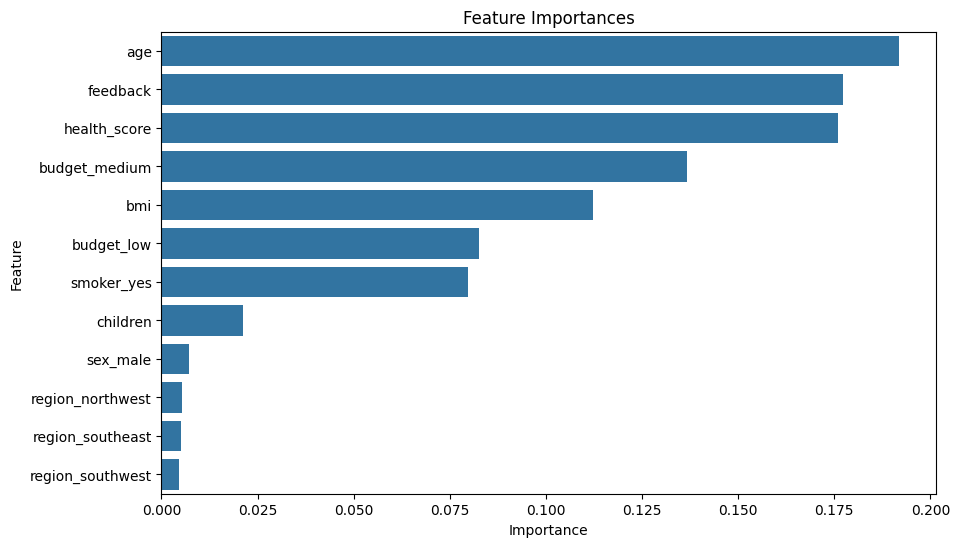

In [42]:
# Feature importance

importances = rf.feature_importances_

# Create a DataFrame for feature importances

importances_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [53]:
importances_df

,Feature,Importance
0,age,0.191966
3,feedback,0.177156
4,health_score,0.175934
11,budget_medium,0.136672
1,bmi,0.112308
10,budget_low,0.082647
6,smoker_yes,0.079679
2,children,0.021322
5,sex_male,0.007169
7,region_northwest,0.005473


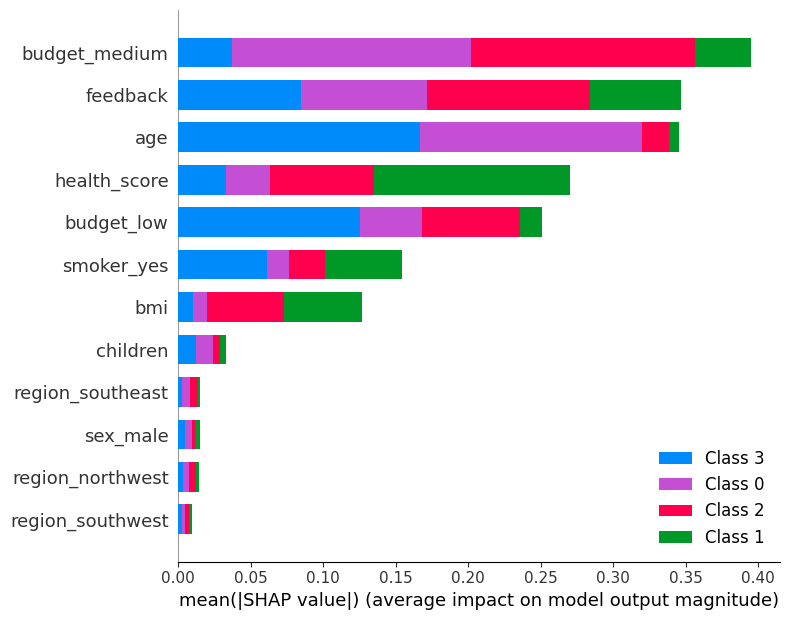

In [43]:
import shap

explainer = shap.TreeExplainer(rf)
# Compute SHAP values
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

In [44]:
cbm = CatBoostClassifier(depth=4, iterations=100,  random_state=42)

# Apply SMOTE to balance classes
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train on balanced data
cbm.fit(X_resampled, y_resampled, verbose=False)

# cbm.fit(X_train, y_train, verbose=False)

y_pred = cbm.predict(X_test)

In [45]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

0.9850746268656716
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        90
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        36
           3       0.97      0.99      0.98       111

    accuracy                           0.99       268
   macro avg       0.99      0.99      0.99       268
weighted avg       0.99      0.99      0.99       268



In [57]:
model_features = X_encoded.columns.tolist()

In [52]:
# Save the model
import joblib

# Assuming you've already trained your model
# cbm.save_model('d:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\insurance_model.cbm')
joblib.dump(cbm, 'd:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\insurance_model.pkl')
# joblib.dump(le, 'd:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\label_encoder.pkl')
# joblib.dump(model_features, 'd:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\model_features.pkl')

['d:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\insurance_model.pkl']

In [8]:
import joblib
from catboost import CatBoost

loaded_model = CatBoost()
loaded_model.load_model('d:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\insurance_model.cbm')

le = joblib.load('d:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\label_encoder.pkl')

model_features = joblib.load('d:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\model_features.pkl')

#### Experiment of utility adjusted ranking

In [46]:
# Basic (Static Preferences)

def get_utility_scores_for_user(user_input_df):
    # Example static mapping (normally you'd fetch this from user profile/preferences)
    preferred_region = user_input_df.iloc[0]["preferred_region"]
    budget_level = user_input_df.iloc[0]["budget"]  # low / medium / high

    # Define utility rules for companies (this could come from a config or DB)
    company_meta = {
        "Company A": {"region": "northwest", "price": "medium"},
        "Company B": {"region": "southeast", "price": "low"},
        "Company C": {"region": "southwest", "price": "high"},
        "Company D": {"region": "northeast", "price": "medium"},
    }

    utility_scores = {}

    for company, meta in company_meta.items():
        score = 1.0  # base utility

        # Increase utility if region matches
        if meta["region"] == preferred_region:
            score += 0.3

        # Modify based on budget match
        if meta["price"] == budget_level:
            score += 0.2

        utility_scores[company] = score

    return utility_scores


In [47]:
model_features

['age',
 'bmi',
 'children',
 'feedback',
 'health_score',
 'sex_male',
 'smoker_yes',
 'region_northwest',
 'region_southeast',
 'region_southwest',
 'budget_low',
 'budget_medium']

In [ ]:
['age', 'bmi', 'children', 'feedback', 'health_score', 'sex_male',
       'smoker_yes', 'region_northwest', 'region_southeast',
       'region_southwest', 'budget_low', 'budget_medium']

In [48]:
def preprocess_user_input(user_input_df, model_features):
    # One-hot encode like training
    user_input_encoded = pd.get_dummies(user_input_df, columns=['sex', 'smoker', 'region', 'budget'], drop_first=True)

    # Add missing columns that existed during training
    for col in model_features:
        if col not in user_input_encoded.columns:
            user_input_encoded[col] = 0

    # Reorder to match model input exactly
    user_input_encoded = user_input_encoded[model_features]

    return user_input_encoded


In [60]:
def health_score(row):
    score = 2
    if row['bmi'] < 25:
        score += 1
    elif row['bmi'] >= 30:
        score -= 1

    score += 1 if row['smoker'] == 'no' else -1
    return score


def recommend_for_user(user_input_df, rf_model, features, get_utility_scores_for_user, top_n=3):

    # Map budget to score
    budget_score = user_input_df['budget'].map({'low': 5, 'medium': 3, 'high': 1})

    # Compute feedback
    user_input_df['feedback'] = (
        budget_score + 
        user_input_df['smoker'].map({'yes': -1, 'no': 1}) + 
        user_input_df['bmi'].apply(lambda x: 1 if x < 25 else -1)
    )

    # Clip to range 0–5
    user_input_df['feedback'] = user_input_df['feedback'].clip(0, 5)


    user_input_df['health_score'] = user_input_df.apply(health_score, axis=1)

    # Preprocess user input to match training features
    user_input_encoded = preprocess_user_input(user_input_df, features)

    # Step 1: Predict class probabilities
    probs = rf_model.predict_proba(user_input_encoded)

    class_names = le.inverse_transform(rf_model.classes_)  # get original labels
    
    # Step 2: Get top-N most probable recommendations
    # top_n_probs = sorted(
    #     list(zip(class_names, probs[0])),
    #     key=lambda x: x[1],
    #     reverse=True
    # )[:top_n]


    prob_dict = dict(zip(class_names, probs[0]))  # {'CompanyA': 0.45, ...}

    # Step 3: Sort and get top-N as a dictionary
    top_n_probs = dict(
        sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    )

    
    # Step 3: Fetch user-specific utility scores
    utility_scores = get_utility_scores_for_user(user_input_df)
    
    # Step 4: Multiply probabilities with utility scores
    recommendations = {
        company: prob * utility_scores.get(company, 1.0)  # Default utility = 1.0 if not found
        for company, prob in top_n_probs.items()
    }
    
    # Step 5: Re-rank based on adjusted utility score
    # recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    
    return recommendations

    # return top_n_probs


2

In [63]:
le.inverse_transform(rf.classes_)

array(['Company A', 'Company B', 'Company C', 'Company D'], dtype=object)

In [163]:
df.head()

,age,sex,bmi,children,smoker,region,charges,insurance_company
0,19,female,27.900,0,yes,southwest,16884.92400,Company C
1,18,male,33.770,1,no,southeast,1725.55230,Company D
2,28,male,33.000,3,no,southeast,4449.46200,Company D
3,33,male,22.705,0,no,northwest,21984.47061,Company C
4,32,male,28.880,0,no,northwest,3866.85520,Company D


In [83]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region',
       'insurance_company', 'budget', 'feedback', 'health_score'],
      dtype='object')

In [61]:
user_input_df = pd.DataFrame({'age':19, 'sex':'female', 'bmi':27.9, 'children':0, 'smoker':'yes', 'region':'southeast', 'budget':'high', 'preferred_region':'southeast'}, index=[0])
# user_input_df = pd.DataFrame({'age':18, 'sex':'male', 'bmi':33.770, 'children':1, 'smoker':'no', 'region':'southeast', 'budget':'low', 'preferred_region':'southeast'}, index=[0])

recommendations = recommend_for_user(
    user_input_df,
    cbm,
    model_features,
    get_utility_scores_for_user,
    top_n=3
)

recommendations

{'Company C': 1.1797164486344032,
 'Company B': 0.014723169680509128,
 'Company A': 0.004648187264333779}

In [89]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ohe_encoder = ohe.fit_transform(df[['sex', 'smoker', 'region', 'budget']])

In [95]:
user_input_df = pd.DataFrame({'age':19, 'sex':'female', 'bmi':27.9, 'children':0, 'smoker':'yes', 'region':'southeast', 'budget':'medium', 'preferred_region':'southeast', 'budget_level':'medium'}, index=[0])

user_input_df = pd.DataFrame([{
    'sex': 'female',
    'smoker': 'yes',
    'region': 'southeast',
    'budget': 'medium'
}])

# Transform using trained encoder
user_encoded = ohe.transform(user_input_df)
user_encoded

# encoded_dff = pd.get_dummies(user_input_df, columns=['sex', 'smoker', 'region', 'budget'], drop_first=True)
# encoded_dff


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 7)>

In [126]:
le.inverse_transform(np.array([2]))

array(['Company C'], dtype=object)

In [114]:
probs.shape

(268, 4)

In [129]:
probs = rf.predict_proba(X_test)[0]
probs

array([0.98, 0.  , 0.  , 0.02])

In [125]:
top_indices = probs.argsort()[::-1]
top_indices

array([0, 3, 2, 1], dtype=int64)

In [117]:
probs = rf.predict_proba(X_test)[0]
top_indices = probs.argsort()[::-1]
top_company_names = le.inverse_transform(top_indices)
top_company_names

array(['Company A', 'Company D', 'Company C', 'Company B'], dtype=object)

In [19]:
df.head()

,age,sex,bmi,children,smoker,region,charges,insurance_company,feedback,avg_feedback_score
0,19,female,27.900,0,yes,southwest,16884.92400,4,1.676116,3.945307
1,18,male,33.770,1,no,southeast,1725.55230,4,4.864706,3.945307
2,28,male,33.000,3,no,southeast,4449.46200,4,4.651134,3.945307
3,33,male,22.705,0,no,northwest,21984.47061,2,5.000000,4.549802
4,32,male,28.880,0,no,northwest,3866.85520,4,4.696814,3.945307


In [ ]:
df.describe()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                              n_iter=20, cv=skf, verbose=2, random_state=42, 
                              scoring='accuracy')
rf_random.fit(X, y)
print(f"Best parameters: {rf_random.best_params_}")
print(f"Best accuracy: {rf_random.best_score_:.4f}")